In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, RocCurveDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from keras import layers, callbacks
from keras.optimizers import Adam
from xgboost import XGBClassifier

In [68]:
seed = 123
kfold = StratifiedKFold(5, shuffle=True, random_state=seed)

In [69]:
data = pd.read_csv("data/data.csv")
data.drop(columns=["Id"], inplace=True)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,NaN,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,NaN,NaN,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [70]:
X = data.drop(columns=["quality"])
y = data["quality"]
encoder = LabelEncoder()
y = encoder.fit_transform(y)
set(y)

{0, 1, 2, 3, 4, 5}

### X = X_train + X_val -> for cross-validation
### X_val               -> for neural network
### train - 80%, val - 10%, test - 10%

In [71]:
X, X_test, y, y_test = train_test_split(X, y, train_size=0.9, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.888, random_state=seed)
print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1028, 11)
(912, 11)
(116, 11)
(115, 11)


In [72]:
preprocessing = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer())
    ]
)

scoring = "f1_weighted"

random_forest_grid = GridSearchCV(
    Pipeline(
        steps=[
            ("preprocessing", preprocessing),
            ("model", RandomForestClassifier(random_state=seed))
        ]
    ),
    param_grid={
        "model__n_estimators": [150, 250, 500, 1000],
        "model__max_depth": [3, 5, 7, 9, 11, 13, 15, 19, 23, 27],
        "model__min_samples_split": [2, 5, 10]
    },
    scoring=scoring,
    cv=kfold,
    n_jobs=-1,
)

svc_grid = GridSearchCV(
    Pipeline(
        steps=[
            ("preprocessing", preprocessing),
            ("model", SVC(random_state=seed))
        ]
    ),
    param_grid={
        "model__C": [0.1, 1, 10, 100, 1000],
    },
    scoring=scoring,
    cv=kfold,
    n_jobs=-1
)

knn_grid = GridSearchCV(
    Pipeline(
        steps=[
            ("preprocessing", preprocessing),
            ("model", KNeighborsClassifier())
        ]
    ),
    param_grid={
        "model__n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19],
        "model__p": [1, 2],
        "model__weights": ["uniform", "distance"]
    },
    scoring=scoring,
    cv=kfold,
    n_jobs=-1
)

xgb_grid = GridSearchCV(
    Pipeline(
        steps=[
            ("preprocessing", preprocessing),
            ("model", XGBClassifier(random_state=seed))
        ]
    ),
    param_grid={
        "model__n_estimators": [15, 35, 60, 85, 110],
        "model__max_depth": [3, 5, 7, 9],
        "model__min_child_weight": [1, 2, 4, 6]
    },
    scoring=scoring,
    cv=kfold,
    n_jobs=-1
)

log_reg_grid = GridSearchCV(
    Pipeline(
        steps=[
            ("preprocessing", preprocessing),
            ("model", LogisticRegression(random_state=seed))
        ]
    ),
    param_grid={
        "model__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    },
    scoring=scoring,
    cv=kfold,
    n_jobs=-1
)

In [73]:
models = {
    "random_forest": random_forest_grid,
    "svc": svc_grid,
    "knn": knn_grid,
    "xgb": xgb_grid,
    "log_reg": log_reg_grid
}

for model_name, model in models.items():
    model.fit(X, y)
    print(model_name + " best params: ")
    print(model.best_params_)
    print(model_name + " score: ")
    print(model.best_score_)
    print()

random_forest best params: 
{'model__max_depth': 15, 'model__min_samples_split': 2, 'model__n_estimators': 500}
random_forest score: 
0.6348644551428988

svc best params: 
{'model__C': 10}
svc score: 
0.5941372655539909

knn best params: 
{'model__n_neighbors': 17, 'model__p': 1, 'model__weights': 'distance'}
knn score: 
0.6112398522891389

xgb best params: 
{'model__max_depth': 7, 'model__min_child_weight': 1, 'model__n_estimators': 60}
xgb score: 
0.6192617839543082

log_reg best params: 
{'model__C': 1}
log_reg score: 
0.5813344835818083



In [74]:
X_train = pd.DataFrame(preprocessing.fit_transform(X_train))
X_val = pd.DataFrame(preprocessing.fit_transform(X_val))

X_train.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-1.138366,-1.277245,1.127651,-0.539789,-0.404883,2.097550e-01,0.444111,-0.418136,0.790764,-3.677370e-16,-0.127945
1,-0.794087,1.158485,-1.198309,-0.163373,-0.768666,-8.662806e-01,-0.919913,-0.843462,0.855114,-1.490813e-01,0.987052
2,-0.105528,1.878133,-1.353373,0.589461,0.249926,9.923263e-01,0.444111,1.838168,1.820363,4.168688e-01,-0.592527
3,0.812549,-0.612955,1.024275,-0.313939,-0.283622,9.880084e-17,-0.919913,-0.112109,-0.303184,5.426355e-01,1.730383
4,-0.621947,-0.834385,0.197267,-0.539789,-0.307874,1.481433e+00,0.716916,0.074620,0.662065,-4.006147e-01,-0.871277


In [75]:
n = 256
neural_network = keras.Sequential([
    layers.Dense(n, input_shape=(X_train.shape[1],), activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(n, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(n, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(n, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(n, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(n, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(n, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(n, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(n, activation="relu"),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(n, activation="relu"),
    layers.Dense(11, activation="softmax"),
])

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,
    patience=40,
    restore_best_weights=True,
)

neural_network.compile(
    optimizer=Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

neural_network.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 256)               3072      
                                                                 
 dropout_44 (Dropout)        (None, 256)               0         
                                                                 
 dense_57 (Dense)            (None, 256)               65792     
                                                                 
 dropout_45 (Dropout)        (None, 256)               0         
                                                                 
 dense_58 (Dense)            (None, 256)               65792     
                                                                 
 dropout_46 (Dropout)        (None, 256)               0         
                                                                 
 dense_59 (Dense)            (None, 256)              

Epoch 1/1000
114/114 [==============================] - 2s 7ms/step - loss: 1.5060 - sparse_categorical_accuracy: 0.3849 - val_loss: 1.6425 - val_sparse_categorical_accuracy: 0.4052
Epoch 2/1000
114/114 [==============================] - 1s 6ms/step - loss: 1.3365 - sparse_categorical_accuracy: 0.4112 - val_loss: 1.3239 - val_sparse_categorical_accuracy: 0.3966
Epoch 3/1000
114/114 [==============================] - 1s 6ms/step - loss: 1.2902 - sparse_categorical_accuracy: 0.4123 - val_loss: 1.2231 - val_sparse_categorical_accuracy: 0.4741
Epoch 4/1000
114/114 [==============================] - 1s 6ms/step - loss: 1.1563 - sparse_categorical_accuracy: 0.4978 - val_loss: 1.1818 - val_sparse_categorical_accuracy: 0.4483
Epoch 5/1000
114/114 [==============================] - 1s 6ms/step - loss: 1.1316 - sparse_categorical_accuracy: 0.5208 - val_loss: 1.3962 - val_sparse_categorical_accuracy: 0.4138
Epoch 6/1000
114/114 [==============================] - 1s 6ms/step - loss: 1.1249 - spars

<Axes: >

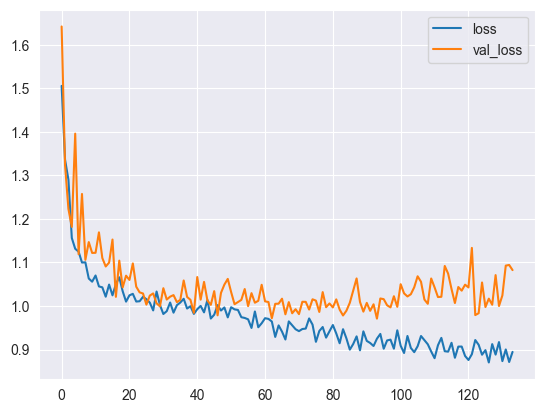

In [76]:
history = neural_network.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=1,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

In [77]:
conv_net = keras.Sequential([
    layers.Dense(256, input_shape=(X_train.shape[1],), activation="elu"),
    layers.Dropout(0.5),
    layers.Reshape((32, 8)),
    layers.Conv1D(filters=16, kernel_size=3, activation="elu"),
    layers.Flatten(),
    layers.Dense(64, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(11, activation="softmax")
])

conv_net.compile(
    optimizer=Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

conv_net.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 256)               3072      
                                                                 
 dropout_53 (Dropout)        (None, 256)               0         
                                                                 
 reshape_4 (Reshape)         (None, 32, 8)             0         
                                                                 
 conv1d_4 (Conv1D)           (None, 30, 16)            400       
                                                                 
 flatten_4 (Flatten)         (None, 480)               0         
                                                                 
 dense_68 (Dense)            (None, 64)                30784     
                                                                 
 dropout_54 (Dropout)        (None, 64)               

Epoch 1/1000
15/15 [==============================] - 2s 22ms/step - loss: 2.2125 - sparse_categorical_accuracy: 0.2950 - val_loss: 1.8419 - val_sparse_categorical_accuracy: 0.5345
Epoch 2/1000
15/15 [==============================] - 0s 8ms/step - loss: 1.7110 - sparse_categorical_accuracy: 0.5022 - val_loss: 1.5583 - val_sparse_categorical_accuracy: 0.5345
Epoch 3/1000
15/15 [==============================] - 0s 8ms/step - loss: 1.4035 - sparse_categorical_accuracy: 0.5768 - val_loss: 1.2473 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/1000
15/15 [==============================] - 0s 8ms/step - loss: 1.2332 - sparse_categorical_accuracy: 0.5833 - val_loss: 1.1019 - val_sparse_categorical_accuracy: 0.5345
Epoch 5/1000
15/15 [==============================] - 0s 7ms/step - loss: 1.1633 - sparse_categorical_accuracy: 0.5866 - val_loss: 1.0453 - val_sparse_categorical_accuracy: 0.5086
Epoch 6/1000
15/15 [==============================] - 0s 7ms/step - loss: 1.1115 - sparse_categoric

<Axes: >

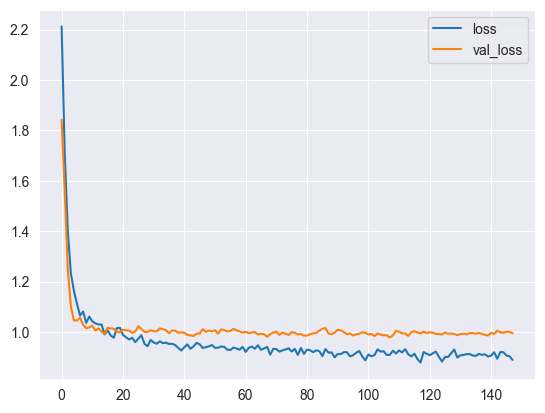

In [78]:
history = conv_net.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=1,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

In [79]:
models_test_scores = []

for model_name, model in models.items():
    models_test_scores.append((model_name, model.score(X_test, y_test)))
models_test_scores.append(("neural_network", f1_score(y_test, neural_network.predict(preprocessing.fit_transform(X_test))
                                                      .argmax(axis=-1), average="weighted")))
models_test_scores.append(("conv_net", f1_score(y_test, conv_net.predict(preprocessing.fit_transform(X_test))
                                                      .argmax(axis=-1), average="weighted")))

test_scores_df = pd.DataFrame(models_test_scores, columns=["model", "score"])
test_scores_df

4/4 [==============================] - 0s 3ms/step


,model,score
0,random_forest,0.739749
1,svc,0.641337
2,knn,0.689097
3,xgb,0.696602
4,log_reg,0.641482
5,neural_network,0.652617
6,conv_net,0.659279


### the best model: random_forest
### I will examine its performance with a little more detail and visualizations

In [80]:
y_proba = random_forest_grid.predict_proba(X_test)
y_proba

array([[0.00000000e+00, 6.00000000e-03, 8.08161774e-02, 3.66789880e-01,
        4.50383129e-01, 9.60108134e-02],
       [0.00000000e+00, 1.81333333e-02, 6.35666667e-01, 2.88133333e-01,
        4.80666667e-02, 1.00000000e-02],
       [1.42000000e-02, 7.05474490e-02, 6.25139982e-01, 2.50699204e-01,
        2.74133653e-02, 1.20000000e-02],
       [0.00000000e+00, 2.96152661e-02, 2.56270994e-01, 4.64935237e-01,
        2.28482237e-01, 2.06962654e-02],
       [2.00000000e-03, 1.29293463e-02, 3.16709225e-01, 6.24024066e-01,
        4.21835170e-02, 2.15384615e-03],
       [1.81739130e-02, 6.21777778e-02, 5.43163360e-01, 3.50397992e-01,
        2.40869565e-02, 2.00000000e-03],
       [0.00000000e+00, 2.79370629e-04, 8.49305109e-01, 1.44275985e-01,
        4.13953488e-03, 2.00000000e-03],
       [2.00000000e-03, 3.02154472e-02, 5.98888954e-01, 3.40365799e-01,
        2.85297999e-02, 0.00000000e+00],
       [1.20000000e-02, 1.16551919e-01, 5.35634121e-01, 2.81685181e-01,
        5.01287785e-02, 

In [87]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape

(115, 6)

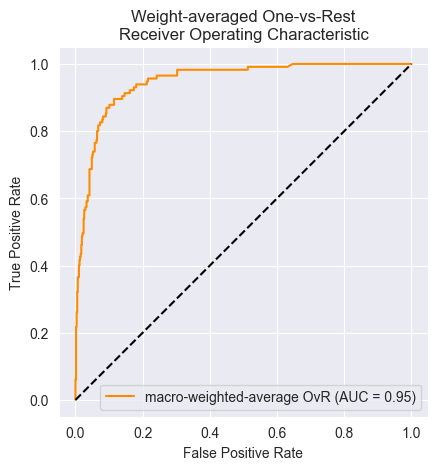

In [88]:
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_proba.ravel(),
    name="macro-weighted-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Weight-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

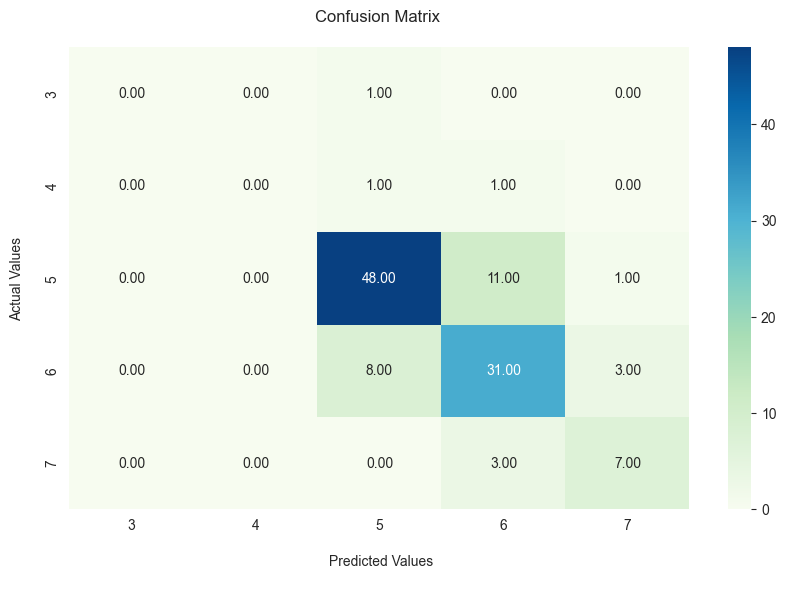

In [89]:
y_test_decoded = encoder.inverse_transform(y_test)

test_pred = encoder.inverse_transform(random_forest_grid.predict(X_test))
labels = encoder.inverse_transform(list(set(y_test)))

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test_decoded, test_pred), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n')
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n')
fx.xaxis.set_ticklabels(labels)
fx.yaxis.set_ticklabels(labels)
plt.show()